# Project Plan


Here all the required libraries should be mentioned. 
If there are any preinstalled libraries, should be be mentioned as well. 

## 1.0 Using own Dataset to  Train and Evaluate the Model



#### 1.1 Project Introduction and Breifing (including Warning)


#### 1.2 Own Data Collection

--> First trying to get the human written contexts from Publicly available resources, like Reddit, Stackoverflow and so on. Labelling them as Human Written Text
<br>
--> Second, Paraphrase these text using AI and labelling them as Machine generated Texts

In [21]:
## Fetching data from Reddit and storing them into 

import praw

# Replace with your credentials
reddit = praw.Reddit(
    client_id="-gz2PzmHRmuiSFoxS3wktQ",
    client_secret="mBz_xNWOY7mvRH-v0yQtLA6_Eikt-g",
    user_agent="MyRedditBot/1.0 by DifferenceThick5740"
)

# Fetch top 5 posts from r/worldnews
subreddit = reddit.subreddit("nosleep")
for post in subreddit.hot(limit=10):
    print(f"Title: {post.title}")
    print(f"Score: {post.score}")
    print(f"URL: {post.url}")
        
    if post.selftext:
        print(f"User-Written Content: {post.selftext}...")
    else:
        print("No user-written content (link post)")

    # print("\nTop Comments:")
    # post.comments.replace_more(limit=0)  # Avoid "load more comments"
        
    # for comment in post.comments.list()[:5]:  # Get first 5 comments
    #     print("---Comment---")
    #     print(f"- {comment.body}")  # Truncate long comments
            
    print("="*50)
    
        


Title: Interested in being a NoSleep moderator?
Score: 19
URL: /r/NoSleepOOC/comments/1e7k7w6/interested_in_being_a_nosleep_moderator/
No user-written content (link post)
Title: Revised Guidelines for r/nosleep Effective January 17, 2025
Score: 34
URL: /r/NoSleepOOC/comments/1i39l19/revised_guidelines_for_rnosleep_effective_january/
No user-written content (link post)
Title: My Girlfriend Will Be A Hollywood Star
Score: 59
URL: https://www.reddit.com/r/nosleep/comments/1j2zfmy/my_girlfriend_will_be_a_hollywood_star/
User-Written Content: \*\*\*I have changed her name to protect her privacy from online weirdos\*\*\*

I first saw her in an indie film. Clara Voss. She wasn’t a household name yet, but she would be. I could tell. There was something about her. The way she lit up the screen, the way she made you feel every word she said. She wasn’t like the others. She was real. Raw. Unpolished in the best way. I couldn’t look away.

It started innocently enough. I followed her on social med

Fetching: The Social Network
Fetching: Pulp Fiction
Fetching: 12 Angry Men
Fetching: The Matrix
Fetching: Pride and Prejudice
✔️ Cleaned dataset saved as 'cleaned_full_sentences_movie_dialogues.csv'
✔️ Analysis completed for: The Social Network
✔️ Analysis completed for: Pulp Fiction
✔️ Analysis completed for: 12 Angry Men
✔️ Analysis completed for: The Matrix
✔️ Analysis completed for: Pride and Prejudice
                     Total Words  Unique Words  Avg Sentence Length  \
The Social Network         28811          3466                 9.86   
Pulp Fiction               27385          3485                 9.09   
12 Angry Men                  91            81                51.50   
The Matrix                 22821          3449                 8.29   
Pride and Prejudice        24595          3285                 8.67   

                     Readability Score  \
The Social Network               77.64   
Pulp Fiction                     86.91   
12 Angry Men                     14.8

,Total Words,Unique Words,Avg Sentence Length,Readability Score,Top Words
The Social Network,28811,3466,9.86,77.64,"[(the, 1330), (to, 828), (and, 784), (a, 753),..."
Pulp Fiction,27385,3485,9.09,86.91,"[(the, 1431), (a, 773), (i, 578), (you, 570), ..."
12 Angry Men,91,81,51.50,14.80,"[(imsdb, 4), (the, 3), (movie, 2), (script, 2)..."
The Matrix,22821,3449,8.29,78.14,"[(the, 1431), (a, 571), (neo, 526), (to, 455),..."
Pride and Prejudice,24595,3285,8.67,70.19,"[(the, 920), (to, 657), (elizabeth, 599), (i, ..."


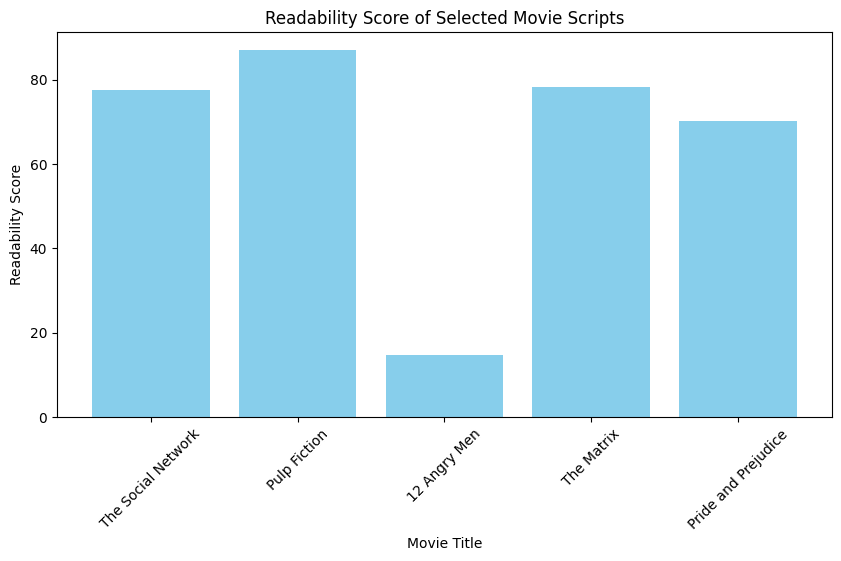

In [43]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import textstat
import nltk
import time
from collections import Counter



# Movie scripts source (you may need to update URLs based on availability)
movie_scripts = {
    "The Social Network": "https://imsdb.com/scripts/Social-Network,-The.html",
    "Pulp Fiction": "https://imsdb.com/scripts/Pulp-Fiction.html",
    "12 Angry Men": "https://imsdb.com/scripts/12-Angry-Men.html",
    "The Matrix": "https://imsdb.com/scripts/Matrix,-The.html",
    "Pride and Prejudice": "https://imsdb.com/scripts/Pride-and-Prejudice.html"
}

def fetch_script(url):
    """Fetch movie script from IMSDb with proper encoding."""
    response = requests.get(url)
    
    # Ensure proper encoding (fixes unwanted symbols)
    response.encoding = 'utf-8'  # Force UTF-8 encoding
    soup = BeautifulSoup(response.text, "html.parser")
    script_text = soup.get_text(separator='\n')

    return script_text

def clean_and_merge_dialogues(script):
    """Extract and clean meaningful full sentences from the script."""
    dialogues = []
    lines = script.split("\n")

    merged_dialogue = ""

    for line in lines:
        line = line.strip()

        # Ignore numbers, standalone character labels, and encoding artifacts
        if re.fullmatch(r"\d+|[A-Z]{2,}|[â€¢â€]+", line):  
            continue

        # Remove stage directions inside parentheses
        line = re.sub(r"\(.*?\)", "", line)

        # Remove unwanted encoding artifacts
        line = line.encode('ascii', 'ignore').decode('utf-8')  # Removes special characters

        # Ensure the line is a valid sentence
        if len(line) > 10 and re.search(r"[.!?]$", line):  # Checks if it ends properly
            merged_dialogue += " " + line.strip()

        # If it is long enough, store it
        if len(merged_dialogue) > 100:  
            dialogues.append(merged_dialogue.strip())
            merged_dialogue = ""

    return dialogues

# Scrape and process scripts
all_dialogues = []
for movie, url in movie_scripts.items():
    print(f"Fetching: {movie}")
    script = fetch_script(url)
    cleaned_dialogues = clean_and_merge_dialogues(script)

    # Add to dataset
    for dialogue in cleaned_dialogues:
        all_dialogues.append({"movie": movie, "dialogue": dialogue, "label": "human"})

    time.sleep(2)  # Avoid getting blocked

# Save dataset
df = pd.DataFrame(all_dialogues)
df.to_csv("cleaned_full_sentences_movie_dialogues.csv", index=False)

print("✔️ Cleaned dataset saved as 'cleaned_full_sentences_movie_dialogues.csv'")




# Fetch and analyze scripts
script_analysis = {}

for movie, url in movie_scripts.items():
    try:
        script = fetch_script(url)
        analysis = analyze_script(script)
        script_analysis[movie] = analysis
        print(f"✔️ Analysis completed for: {movie}")
    except Exception as e:
        print(f"❌ Error fetching {movie}: {e}")

# Display results
import pandas as pd
df = pd.DataFrame.from_dict(script_analysis, orient='index')

print(df)

# Save as CSV
df.to_csv("movie_script_analysis.csv", index=True)

# Display DataFrame in Jupyter Notebook (if applicable)
from IPython.display import display
display(df)




# Plot readability scores
plt.figure(figsize=(10,5))
plt.bar(df.index, df["Readability Score"], color='skyblue')
plt.xlabel("Movie Title")
plt.ylabel("Readability Score")
plt.title("Readability Score of Selected Movie Scripts")
plt.xticks(rotation=45)
plt.show()


In [1]:
from transformers import pipeline
from huggingface_hub import login

# 🔑 Authenticate with Hugging Face
login()




In [2]:
import pandas as pd
# from transformers import pipeline  # Import pipeline correctly
import torch
import time

# ✅ Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # 0 = GPU, -1 = CPU

model_id = "meta-llama/Meta-Llama-3-8B"

# ✅ Load AI text-generation model
try:
    generator = pipeline("text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, device_map="auto")  
except Exception as e:
    print(f"⚠️ Error loading model: {e}")
    print("🔄 Switching to GPT-2 for lightweight generation.")
    generator = pipeline("text-generation", model="gpt2", device=device)

# ✅ Load cleaned human movie dialogues
df_human = pd.read_csv("cleaned_full_sentences_movie_dialogues.csv")

# ✅ Select dialogue sentences
human_sentences = df_human["dialogue"].tolist()

# ✅ Define AI-generated dialogues storage
ai_dialogues = []

# ✅ Define a proper prompt template
prompt_template = """
This is a movie dialogue from a film:

"{human_sentence}"

Now generate a unique, realistic movie dialogue in a similar style.
It should be only 50 words and straightaway, just prompt the dialogue without any info
"""

# ✅ Generate AI dialogues based on human-written sentences
for sentence in human_sentences[:50]:  # Adjust the number of AI generations as needed
    prompt = prompt_template.format(human_sentence=sentence)
    
    try:
        result = generator(prompt, max_length=150, do_sample=True)
        ai_generated_text = result[0]['generated_text'].strip()

        # Store the AI-generated dialogue
        ai_dialogues.append({"movie": "AI-Generated", "dialogue": ai_generated_text, "label": "ai"})
    
    except Exception as e:
        print(f"❌ Error generating for sentence: {sentence} | Error: {e}")
    
    time.sleep(1)  # Prevent rate-limiting

# ✅ Save AI-generated dialogues into a CSV
df_ai = pd.DataFrame(ai_dialogues)
df_ai.to_csv("ai_generated_movie_dialogues.csv", index=False)

print("✔️ AI-generated movie dialogues saved as 'ai_generated_movie_dialogues.csv'")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad

✔️ AI-generated movie dialogues saved as 'ai_generated_movie_dialogues.csv'


In [81]:
!pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu transformers


Found existing installation: transformers 4.49.0
Uninstalling transformers-4.49.0:
  Successfully uninstalled transformers-4.49.0


In [87]:
!pip install --no-cache-dir tensorflow transformers


   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
    --------------------------------------- 6.6/390.2 MB 33.5 MB/s eta 0:00:12
   - -------------------------------------- 13.9/390.2 MB 34.9 MB/s eta 0:00:11
   -- ------------------------------------- 21.2/390.2 MB 34.4 MB/s eta 0:00:11
   -- ------------------------------------- 28.6/390.2 MB 34.2 MB/s eta 0:00:11
   --- ------------------------------------ 35.7/390.2 MB 33.8 MB/s eta 0:00:11
   ---- ----------------------------------- 42.2/390.2 MB 33.6 MB/s eta 0:00:11
   ---- ----------------------------------- 48.8/390.2 MB 33.0 MB/s eta 0:00:11
   ----- ---------------------------------- 55.8/390.2 MB 33.2 MB/s eta 0:00:11
   ------ --------------------------------- 62.9/390.2 MB 33.1 MB/s eta 0:00:10
   ------- -------------------------------- 70.3/390.2 MB 33.2 MB/s eta 0:00:10
   ------- -------------------------------- 77.9/390.2 MB 33.3 MB/s eta 0:00:10
   -------- ------------------------------- 85.2/3

In [1]:
import tensorflow as tf
from tensorflow import keras
import transformers

print("TensorFlow Version:", tf.__version__)
print("Transformers Loaded Successfully!")


ImportError: cannot import name 'get_model_proto' from 'tensorflow.python.data.experimental.ops.iterator_ops' (c:\Users\tgish\anaconda3\envs\tensorflow\Lib\site-packages\tensorflow\python\data\experimental\ops\iterator_ops.py)

#### 1.3 Data Analysis and Preprocesssing  



#### 1.4 Building the statistical classifier model (for example, a logistic regression classifier)
-- Check the Marking Rubric in Parallal to the development (Mark the completed Rubrics)



#### 1.5 Developing the Deep Learning-Based Classification Model
-- (1) train (2) validate and (3) test your classifier based on your dataset.
-- Check the Marking Rubric in Parallal to the development (Mark the completed Rubrics)





## 2.0 Using own Dataset to  Train and Evaluate the Model
#### 2.1 Project Introduction and Breifing (including Warning)

#### 2.2 Fetch a Exsisting Dataset

#### 2.3 Data Analysis and Preprocesssing  

#### 2.4 Building the statistical classifier model (for example, a logistic regression classifier) - Requires HyperParameter Changes and Finetuning
-- Check the Marking Rubric in Parallal to the development (Mark the completed Rubrics)

#### 2.5 Developing the Deep Learning-Based Classification Model                                   - Require HyperParameters changes and changes based on the structure of the choosen dataset
-- (1) train (2) validate and (3) test your classifier based on your dataset.
-- Check the Marking Rubric in Parallal to the development (Mark the completed Rubrics)


## 3.0 Evaluate the both the datasets performance based on both the models


#### 2.1 Project Introduction and Breifing (including Warning)

#### 2.2 Fetch a Exsisting Dataset

#### 2.3 Data Analysis and Preprocesssing  

#### 2.4 Building the statistical classifier model (for example, a logistic regression classifier) - Requires HyperParameter Changes and Finetuning
-- Check the Marking Rubric in Parallal to the development (Mark the completed Rubrics)

#### 2.5 Developing the Deep Learning-Based Classification Model                                   - Require HyperParameters changes and changes based on the structure of the choosen dataset
-- (1) train (2) validate and (3) test your classifier based on your dataset.
-- Check the Marking Rubric in Parallal to the development (Mark the completed Rubrics)


## 3.0 Evaluate the both the datasets performance based on both the models